# HR Data Regression

The objective of this notebook is to analyze Human Resources data of employees that have left the company. I will use different regression methods to transform data and derive a model that can accurately predict the amount of years an employee will stay with the company. This type of analysis can benefit Human Resources personnel because they can identify factors that influence turnover rate and find ways to prevent employees from leaving the organization.

In [1]:
#Import python libraries
#Data can be found at https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge, ElasticNet, RidgeCV, LassoCV, ElasticNetCV, SGDRegressor, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
import warnings
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.stats.mstats import normaltest
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.pipeline import Pipeline



In [2]:
#Import data into dataframe
data = pd.read_csv('HRData.csv')
data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,Sales,1,2,Life Sciences,1,1,2,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,Research & Development,8,1,Life Sciences,1,2,3,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,Research & Development,2,2,Other,1,4,4,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,Research & Development,3,4,Life Sciences,1,5,4,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,Research & Development,2,1,Medical,1,7,1,...,3,4,1,6,3,3,2,2,2,2


In [5]:
#Get information about dataframe columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   Department                1470 non-null   object
 4   DistanceFromHome          1470 non-null   int64 
 5   Education                 1470 non-null   int64 
 6   EducationField            1470 non-null   object
 7   EmployeeCount             1470 non-null   int64 
 8   EmployeeNumber            1470 non-null   int64 
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobLevel                  1470 non-null   int64 
 14  JobRole                 

In [3]:
#Check for null values
for c in data.columns:
    print(c, data[c].isnull().sum()) 

Age 0
Attrition 0
BusinessTravel 0
Department 0
DistanceFromHome 0
Education 0
EducationField 0
EmployeeCount 0
EmployeeNumber 0
EnvironmentSatisfaction 0
Gender 0
HourlyRate 0
JobInvolvement 0
JobLevel 0
JobRole 0
JobSatisfaction 0
MaritalStatus 0
MonthlyIncome 0
NumCompaniesWorked 0
Over18 0
OverTime 0
PercentSalaryHike 0
PerformanceRating 0
RelationshipSatisfaction 0
StockOptionLevel 0
TotalWorkingYears 0
TrainingTimesLastYear 0
WorkLifeBalance 0
YearsAtCompany 0
YearsInCurrentRole 0
YearsSinceLastPromotion 0
YearsWithCurrManager 0


In [4]:
#Print number of unique values for each column
print('Unique Values')
for c in data.columns:
    print(c, data[c].unique().size,data[c].dtype)

Unique Values
Age 43 int64
Attrition 2 object
BusinessTravel 3 object
Department 3 object
DistanceFromHome 29 int64
Education 5 int64
EducationField 6 object
EmployeeCount 1 int64
EmployeeNumber 1470 int64
EnvironmentSatisfaction 4 int64
Gender 2 object
HourlyRate 71 int64
JobInvolvement 4 int64
JobLevel 5 int64
JobRole 9 object
JobSatisfaction 4 int64
MaritalStatus 3 object
MonthlyIncome 1349 int64
NumCompaniesWorked 10 int64
Over18 1 object
OverTime 2 object
PercentSalaryHike 15 int64
PerformanceRating 2 int64
RelationshipSatisfaction 4 int64
StockOptionLevel 4 int64
TotalWorkingYears 40 int64
TrainingTimesLastYear 7 int64
WorkLifeBalance 4 int64
YearsAtCompany 37 int64
YearsInCurrentRole 19 int64
YearsSinceLastPromotion 16 int64
YearsWithCurrManager 18 int64


<AxesSubplot:xlabel='YearsAtCompany', ylabel='Count'>

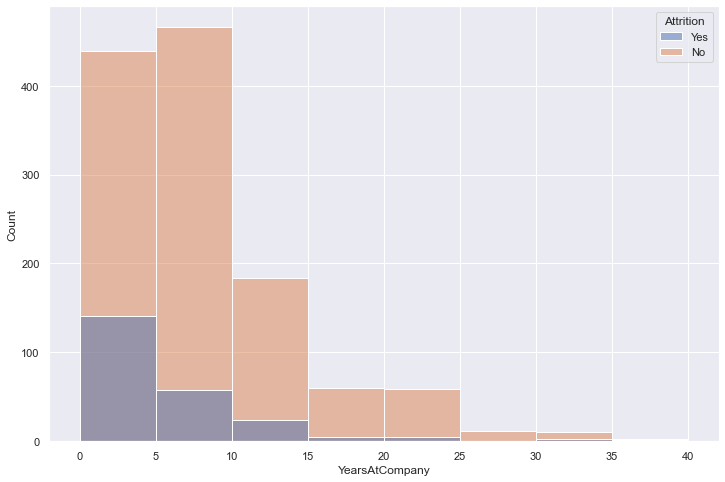

In [5]:
#Display histgram of YearsAtCompany by Attrition category

sns.set(rc={"figure.figsize":(12, 8)})
sns.histplot(data, x='YearsAtCompany', hue='Attrition', bins=8)

The histogram above shows the distribution of employees leaving the company skewed towards less YearsAtCompany. Only the employees with Attrition value of 'Yes' will be selected for analysis.

In [6]:
#Select rows where Attrition= 'Yes' and Drop unecessary columns
data2=data[data.Attrition=='Yes']
data2=data2.drop(columns=['Attrition','Department','Over18','EmployeeCount'])
data2.shape

(237, 28)

In [7]:
#Create dummy variables for categorical features
data3=data2.copy()

for i in data3.columns:
    if data3[i].dtype=='object':
        data3=pd.get_dummies(data3,columns=[i],drop_first=True)

data3.head()

,Age,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1,2,1,2,94,3,2,4,5993,...,0,0,0,0,0,1,0,0,1,1
2,37,2,2,4,4,92,2,1,3,2090,...,1,0,0,0,0,0,0,0,1,1
14,28,24,3,19,3,50,2,1,3,2028,...,1,0,0,0,0,0,0,0,1,1
21,36,9,4,27,3,82,2,1,1,3407,...,0,0,0,0,0,0,1,0,1,0
24,34,6,1,31,2,83,3,1,1,2960,...,0,0,0,0,1,0,0,0,1,0


JobRole_Sales Representative       -0.205922
JobRole_Laboratory Technician      -0.197441
MaritalStatus_Single               -0.110438
Gender_Male                        -0.101169
PercentSalaryHike                  -0.088777
OverTime_Yes                       -0.086370
JobRole_Research Scientist         -0.067990
BusinessTravel_Travel_Frequently   -0.059483
PerformanceRating                  -0.058423
JobRole_Human Resources            -0.037501
WorkLifeBalance                    -0.032627
EducationField_Other               -0.031884
DistanceFromHome                   -0.029204
JobInvolvement                     -0.026785
TrainingTimesLastYear              -0.026311
EducationField_Life Sciences       -0.000941
NumCompaniesWorked                 -0.000311
YearsAtCompany                      0.000000
EducationField_Medical              0.001222
EmployeeNumber                      0.006834
HourlyRate                          0.015526
EducationField_Technical Degree     0.016250
Environmen

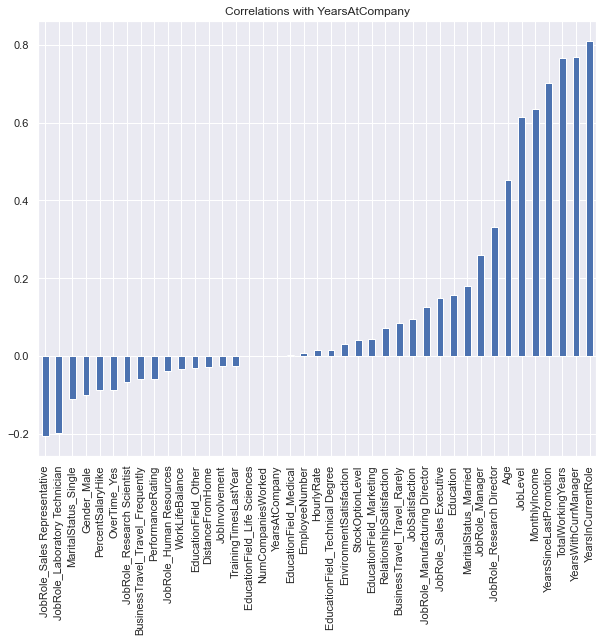

In [8]:
#Plot correlations with YearsAtCompany variable
corr_matrix = data3.corr()

for i in range(corr_matrix.shape[1]):
    corr_matrix.iloc[i,i] = 0
 
correlations=corr_matrix['YearsAtCompany']
correlations=correlations.sort_values()
print(correlations[:])
ax = correlations[:].plot(kind='bar',title='Correlations with YearsAtCompany',figsize=(10,8))

An important part of the analysis is identifying features that are highly correlated with YearsAtCompany. 

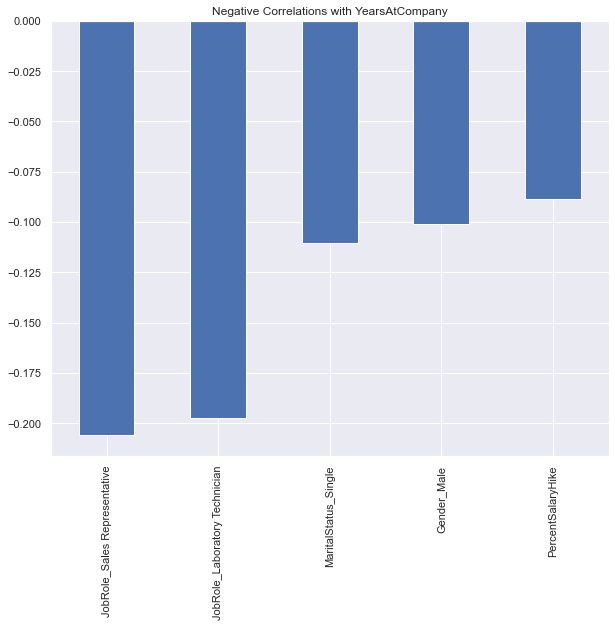

In [9]:
ax = correlations[:5].plot(kind='bar',title='Negative Correlations with YearsAtCompany',figsize=(10,8))

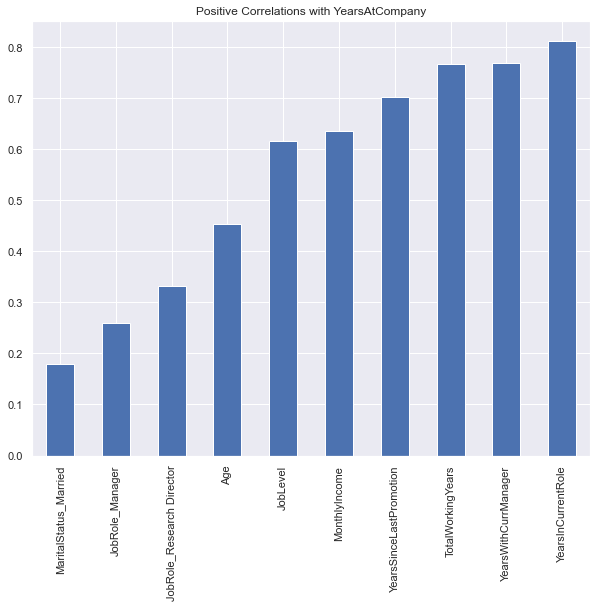

In [10]:
ax = correlations[-10:].plot(kind='bar',title='Positive Correlations with YearsAtCompany',figsize=(10,8))

Sales Representatives and Laboratory Technicians are more likely to leave the company with less YearsAtCompany. The Manager role and Married status are positively correlated with YearsAtCompany.

<AxesSubplot:>

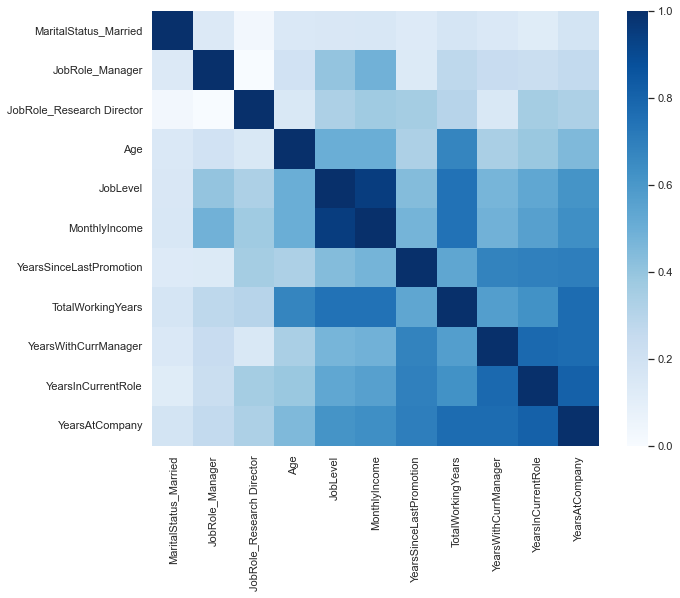

In [11]:
coor3=data3.loc[:,correlations[-10:].index]
coor3=pd.concat([coor3,data3['YearsAtCompany']],axis=1)


#Show Correlation Heatmap of 10 most correlated features
sns.set(rc = {'figure.figsize':(10,8)})
sns.heatmap(coor3.corr(),vmin=0, cmap='Blues')

In [12]:
#Split dataframe into x and y variables

x = data3.drop(columns='YearsAtCompany')
y = data3['YearsAtCompany']

In [13]:
#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 10)


In [14]:
#Define Root Mean Squared Error function
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

In [15]:
#Scale data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc=scaler.transform(X_test)

Here are regression models with different polynomial degrees and the results.

In [16]:
#Linear Regression
LR=LinearRegression()
LR = LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)
LinearReg_rmse=rmse(y_test,y_test_pred)
LinearReg_r2=r2_score(y_test, y_test_pred)
print(X_train.shape[1],' features with degree 1')
print('rmse: ', rmse(y_test, y_test_pred))
print('r2: ',LinearReg_r2)

40  features with degree 1
rmse:  2.6018991399670517
r2:  0.7157259452143234


In [17]:
#Linear Regression with Polynomial Features degree 2
lr=LinearRegression()
pf=PolynomialFeatures(degree=2,include_bias=False)
x_poly=pf.fit_transform(X_train)
x_test_poly=pf.transform(X_test)
scaler = StandardScaler()
x_scpoly = scaler.fit_transform(x_poly)
x_test_scpoly=scaler.transform(x_test_poly)
lr=lr.fit(x_scpoly, y_train)
ypred=lr.predict(x_test_scpoly)
print(x_poly.shape[1],' polynomial features with degree 2')
print('r2: ',r2_score(y_test,ypred))
print('rmse: ', rmse(y_test, ypred))


860  polynomial features with degree 2
r2:  0.6684051659663903
rmse:  2.810125548975847


In [18]:
#Linear Regression with Polynomial Features degree 3
lr=LinearRegression()
pf=PolynomialFeatures(degree=3,include_bias=False)
x_poly=pf.fit_transform(X_train)
x_test_poly=pf.transform(X_test)
scaler = StandardScaler()
x_scpoly = scaler.fit_transform(x_poly)
x_test_scpoly=scaler.transform(x_test_poly)
lr=lr.fit(x_scpoly, y_train)
ypred=lr.predict(x_test_scpoly)
print(x_poly.shape[1],' polynomial features with degree 3')
print('r2: ',r2_score(y_test,ypred))
print('rmse: ', rmse(y_test, ypred))

12340  polynomial features with degree 3
r2:  0.756579563162221
rmse:  2.4076888647269707


In [19]:
#Create KFold object

kf = KFold(shuffle=True, random_state=0, n_splits=3)

The next models use different types of regularization for linear regression.

In [24]:
#RidgeCV

alphas = [1,5,10,15,20, 25, 40, 50, 60, 65, 80, 75, 80, 90, 100]

ridgecv = RidgeCV(alphas=alphas, 
                  cv=kf).fit(X_train_sc, y_train)

ridgecv_ypred=ridgecv.predict(X_test_sc)
ridgeCV_rmse = rmse(y_test, ridgecv_ypred)
ridge_r2=r2_score(y_test, ridgecv_ypred)

print('Best Alpha:',ridgecv.alpha_,' RMSE:', ridgeCV_rmse,' R2:', ridge_r2)


Best Alpha: 50  RMSE: 2.5443904568749165  R2: 0.7281534504083642


In [25]:
#LassoCV

alphas2 = np.array([.003,.01,.03,.1,.3, 1, 3])

lassocv = LassoCV(alphas=alphas2,
                  max_iter=5000,
                  cv=kf).fit(X_train_sc, y_train)

lassocv_ypred= lassocv.predict(X_test_sc)
lassoCV_rmse = rmse(y_test, lassocv_ypred)
lasso_r2= r2_score(y_test, lassocv_ypred)

print('Best Alpha:',lassocv.alpha_,' RMSE:', lassoCV_rmse,' R2:', lasso_r2) 

Best Alpha: 0.1  RMSE: 2.3414089268753244  R2: 0.769797069097064


In [26]:
#ElasticNetCV

l1_ratios = [.05,.1,.2,.3,.4,.5,.6,.7,.8,.9]

elasticNetCV = ElasticNetCV(alphas=alphas2, 
                            l1_ratio=l1_ratios,
                            max_iter=1e4).fit(X_train_sc, y_train)

elasticnetcv_ypred= elasticNetCV.predict(X_test_sc)
elasticNetCV_rmse = rmse(y_test, elasticnetcv_ypred)
elasticnet_r2= r2_score(y_test, elasticnetcv_ypred)

print('Best Alpha:',elasticNetCV.alpha_,' Best l1_ratio:',elasticNetCV.l1_ratio_,' RMSE:',elasticNetCV_rmse,' R2:',elasticnet_r2)

Best Alpha: 0.3  Best l1_ratio: 0.1  RMSE: 2.4827181084265626  R2: 0.74117207368326


In [27]:
#Display error and r2score metrics

errors = [LinearReg_rmse, ridgeCV_rmse, lassoCV_rmse, elasticNetCV_rmse]
r2scores=[LinearReg_r2,ridge_r2,lasso_r2 , elasticnet_r2]

labels = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']

rmse_list = pd.DataFrame(labels)
rmse_list.columns=['Model']
rmse_list['RMSE']=errors
rmse_list['R2']= r2scores
rmse_list.set_index('Model')


,RMSE,R2
Model,,
Linear,2.601899,0.715726
Ridge,2.544390,0.728153
Lasso,2.341409,0.769797
ElasticNet,2.482718,0.741172


Lasso regression appears to have the best results with r2 of 0.76. The next graph will show r2 scores with different alpha values to illustrate how regularization can increase or decrease model performance.

In [28]:
#R2 scores with different lasso alpha values
scores = []

s=StandardScaler()

for alpha in alphas2:
    la = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("lasso_regression", la)])

    predictions = cross_val_predict(estimator, X_train, y_train, cv = kf)
    
    score = r2_score(y_train, predictions)
    
    scores.append(score)

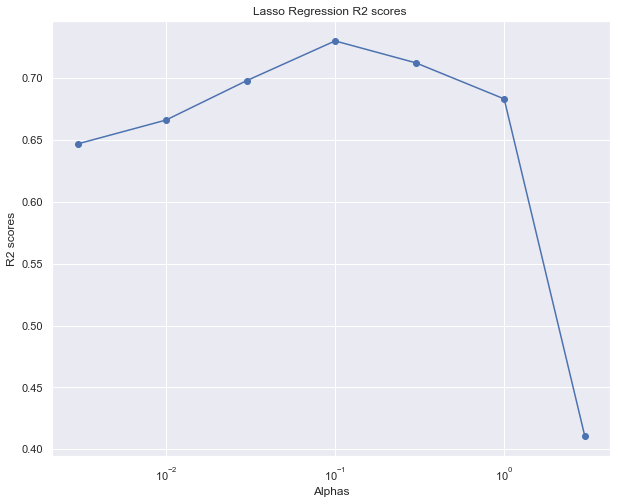

In [29]:
#Plot r2 scores with different alphas
plt.figure(figsize=(10,8))
plt.semilogx(alphas2, scores, '-o')
plt.title('Lasso Regression R2 scores ')
plt.xlabel('Alphas')
plt.ylabel('R2 scores');

The next regression models use GridSearchCV which will find the combination of parameters with best results.

In [30]:
#GridSearchCV
estimator = Pipeline([("polynomial_features", PolynomialFeatures(include_bias=False)), ("scaler", StandardScaler()),
                          ("linear_regression", LinearRegression())])

params = {
    'polynomial_features__degree': [1, 2, 3]
}

lr_grid = GridSearchCV(estimator, params, cv=kf)

In [31]:
#Fit GridSearchCV model
warnings.simplefilter("ignore")
lr_grid.fit(X_train, y_train)
lr_grid_ypred=lr_grid.predict(X_test)
lr_grid_r2=r2_score(y_test, lr_grid_ypred)
lr_grid_rmse=rmse(y_test, lr_grid_ypred)
print('Best Parameters:', lr_grid.best_params_,' RMSE:',lr_grid_rmse,' R2:', lr_grid_r2)
warnings.simplefilter("default")

Best Parameters: {'polynomial_features__degree': 3}  RMSE: 2.4076888647269707  R2: 0.756579563162221


In [32]:
#Ridge GridSearchCV
    
estimator2 = Pipeline([("polynomial_features", PolynomialFeatures(include_bias=False)), ("scaler", StandardScaler()),
                          ("ridge_regression", Ridge())])

params2 = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': alphas 
}

r_grid = GridSearchCV(estimator2, params2, cv=kf)

In [33]:
#Fit GridSearchCV model
r_grid.fit(X_train, y_train)
r_grid_ypred=r_grid.predict(X_test)
r_grid_r2=r2_score(y_test, r_grid_ypred)
r_grid_rmse=rmse(y_test, r_grid_ypred)
print('Best Parameters:', r_grid.best_params_,' RMSE:',r_grid_rmse,' R2:', r_grid_r2)

Best Parameters: {'polynomial_features__degree': 1, 'ridge_regression__alpha': 50}  RMSE: 2.5443904568749174  R2: 0.7281534504083641


In [34]:
#Lasso GridSearchCV

estimator3 = Pipeline([("polynomial_features", PolynomialFeatures(include_bias=False)), ("scaler", StandardScaler()),
                          ("lasso_regression", Lasso(max_iter=10000))])

params3 = {
    'polynomial_features__degree': [1, 2, 3],
    'lasso_regression__alpha': alphas2
   
}

l_grid = GridSearchCV(estimator3, params3, cv=kf)

In [35]:
#Fit GridSearchCV model

warnings.simplefilter("ignore")
l_grid.fit(X_train, y_train)
l_grid_ypred=l_grid.predict(X_test)
l_grid_r2= r2_score(y_test, l_grid_ypred)
l_grid_rmse=rmse(y_test, l_grid_ypred)
print('Best Parameters:', l_grid.best_params_,' RMSE:', l_grid_rmse, ' R2:',l_grid_r2)
warnings.simplefilter("default")

Best Parameters: {'lasso_regression__alpha': 0.3, 'polynomial_features__degree': 3}  RMSE: 2.1479338986376884  R2: 0.8062694402766902


In [36]:
#ElasticNet GridSearchCV

estimator4 = Pipeline([("polynomial_features", PolynomialFeatures(include_bias=False)), ("scaler", StandardScaler()),
                          ("elastic_net", ElasticNet(max_iter=5000))])

params4 = {'polynomial_features__degree': [1, 2, 3], 'elastic_net__alpha': alphas2, 'elastic_net__l1_ratio': l1_ratios}

el_grid = GridSearchCV(estimator4, params4, cv=kf)

In [37]:
#Fit GridSearchCV model
warnings.simplefilter("ignore")
el_grid.fit(X_train, y_train)
el_grid_ypred=el_grid.predict(X_test)
el_grid_rmse=rmse(y_test, el_grid_ypred)
el_grid_r2=r2_score(y_test, el_grid_ypred)
print('Best parameters:', el_grid.best_params_,' RMSE:',el_grid_rmse,' R2:', el_grid_r2)
warnings.simplefilter("default")

Best parameters: {'elastic_net__alpha': 0.3, 'elastic_net__l1_ratio': 0.7, 'polynomial_features__degree': 3}  RMSE: 2.1242544333467843  R2: 0.8105173823893359


In [39]:
#Display results of GridSeachCV models

grid_errors = [lr_grid_rmse, r_grid_rmse, l_grid_rmse, el_grid_rmse]
grid_r2scores=[lr_grid_r2, r_grid_r2, l_grid_r2 , el_grid_r2]

labels = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']

rmse_list = pd.DataFrame(labels)
rmse_list.columns=['Model']
rmse_list['RMSE']=grid_errors
rmse_list['R2']= grid_r2scores
rmse_list.set_index('Model')

,RMSE,R2
Model,,
Linear,2.407689,0.756580
Ridge,2.544390,0.728153
Lasso,2.147934,0.806269
ElasticNet,2.124254,0.810517


ElasticNet has the highest r2 score of 0.81 which is better than the Linear Lasso regression r2 score of 0.76. The model has degree 3 polynomial parameters which increases the complexity. It is common for ElasticNet and Lasso regression to reduce some coeficients to zero. Only 73 out of 12340 coeficients of this model are not zero after regularization.

In [50]:
#Display number of nonzero coeficients

totalcoef=np.array(el_grid.best_estimator_.named_steps['elastic_net'].coef_)
nozero=np.array(np.nonzero(el_grid.best_estimator_.named_steps['elastic_net'].coef_))
print(nozero.size,'nonzero coefficients out of ',totalcoef.size,' total coefficients')



73 nonzero coefficients out of  12340  total coefficients


In [51]:
#DataFrame of variable names and coeficient values
df_importances = pd.DataFrame( zip(el_grid.best_estimator_.named_steps["polynomial_features"].get_feature_names(),
                 el_grid.best_estimator_.named_steps["elastic_net"].coef_ ))

In [52]:
#Display positive coeficients

df_importances.columns=['variable','coeficient']
df_importances[df_importances.coeficient>0].sort_values(by='coeficient', ascending=False).head()


,variable,coeficient
9444,x15 x16 x20,0.590265
6564,x8 x15 x20,0.500890
9442,x15 x16 x18,0.471846
2680,x2 x8 x15,0.295512
9509,x15 x19^2,0.251812


In [53]:
#Display negative coeficients
df_importances[df_importances.coeficient<0].sort_values(by='coeficient').head()

,variable,coeficient
3279,x3 x5 x10,-0.133199
9110,x14 x15 x35,-0.131457
9752,x16^2 x28,-0.088194
7376,x9 x37 x39,-0.075871
7493,x10 x13 x39,-0.030901


The cv results show a summary of every iteration from the ElasticNet model. There are (7 alpha values * 10 l1ratio values * 3 polynomial degrees) = 210 different combinations. Also displayed were the highest and lowest coeficients in the final model. Because there are many interaction terms it can be difficult to interpret their importance.

In [54]:
#GridSearchCV results
pd.DataFrame(el_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_elastic_net__alpha,param_elastic_net__l1_ratio,param_polynomial_features__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010107,0.004866,0.003025,0.001653,0.003,0.05,1,"{'elastic_net__alpha': 0.003, 'elastic_net__l1...",0.739858,0.650546,0.412438,0.600947,0.138193,181
1,0.476022,0.041333,0.003178,0.000292,0.003,0.05,2,"{'elastic_net__alpha': 0.003, 'elastic_net__l1...",0.838276,0.659330,0.406414,0.634673,0.177167,157
2,5.295452,0.315823,0.013966,0.002809,0.003,0.05,3,"{'elastic_net__alpha': 0.003, 'elastic_net__l1...",0.845432,0.678448,0.425334,0.649738,0.172702,149
3,0.005673,0.000209,0.001354,0.000453,0.003,0.1,1,"{'elastic_net__alpha': 0.003, 'elastic_net__l1...",0.739152,0.650399,0.412559,0.600703,0.137884,184
4,0.384142,0.033977,0.002677,0.000489,0.003,0.1,2,"{'elastic_net__alpha': 0.003, 'elastic_net__l1...",0.880371,0.643745,0.344596,0.622904,0.219225,169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,0.016163,0.000495,0.005246,0.007420,3.0,0.8,2,"{'elastic_net__alpha': 3.0, 'elastic_net__l1_r...",0.700421,0.449721,0.686464,0.612202,0.115033,177
206,0.214518,0.067104,0.015622,0.000011,3.0,0.8,3,"{'elastic_net__alpha': 3.0, 'elastic_net__l1_r...",0.753387,0.569196,0.654019,0.658867,0.075274,129
207,0.005208,0.007365,0.000000,0.000000,3.0,0.9,1,"{'elastic_net__alpha': 3.0, 'elastic_net__l1_r...",0.473566,0.326952,0.656535,0.485684,0.134824,210
208,0.013690,0.005878,0.001662,0.001244,3.0,0.9,2,"{'elastic_net__alpha': 3.0, 'elastic_net__l1_r...",0.672495,0.422556,0.629577,0.574876,0.109122,203


An important metric for Human Resources to analyze is employee retention. This can be an indicator of career growth opportunities and employee engagement among other factors. The Lasso and ElasticNet models with polynomial features had the best results. Next steps would be to analze real HR data from different companies to compare the most influential features. This may reveal why some features are more correlated to high employee retention and provide HR enough information to predict the churn rate within their own organization.